Import data and create dataframes:
We will be working with two datasets, one from Foursquare and one from the West Virginia Department of Transportation.

#### Dataset description
The Foursquare dataset corresponds to all businesses in a 10-mile radious of the Falling Water's WV town. From this dataset we are looking to learn the number and type of businesses in the area as well as the business proximity to potential locations. From the dataset we will also learn if the identified business are competitors or business that could attract potential fast food customers.

The following section pulls the datasets and create the corresponding dataframes

In [0]:
# Install necessary libraries 
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install -U folium
print('Folium installed')
#!conda install -c conda-forge geopy --yes
!pip install -U geopy
print('geopy library install')


     |████████████████████████████████| 92kB 5.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.9.1 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


Folium installed
     |████████████████████████████████| 102kB 4.5MB/s 
  Found existing installation: geopy 1.17.0
    Uninstalling geopy-1.17.0:
      Successfully uninstalled geopy-1.17.0


geopy library install


In [2]:
# Import necessary libraries
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # Map plotting library
# import clustering libraries
from sklearn.cluster import KMeans

# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


print('Libraries imported')

Libraries imported


In [3]:
#Set up Foursquare credentials
CLIENT_ID = '3DAUBXTARLYYR4GT30CHA5Z5WZQZMUXL54WPZFFLRTFK34CH' # your Foursquare ID
CLIENT_SECRET = 'FC2KX2BX4WZHA4XZDRQ14HKORJNGDGLYWJ0NKC20R2VKXNKP' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 800
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3DAUBXTARLYYR4GT30CHA5Z5WZQZMUXL54WPZFFLRTFK34CH
CLIENT_SECRET:FC2KX2BX4WZHA4XZDRQ14HKORJNGDGLYWJ0NKC20R2VKXNKP


Set up variables to be used in the Foursquare search request URL

The following section sets up the Foursquare URL to search for all business locations in a 10-miles radius. Something to notice here is that we are not searching by search_queary which queries the name of the business, but by category. For this, I had to include the variable &category to the URL and populate the category value to the category for "Fast Food" as found in the Foursquare website.

## 1. Search for a specific venue category
> `https://api.foursquare.com/v2/venues/`**explore**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&category=`**CATEGORY**`&radius=`**RADIUS**`&limit=`**LIMIT**


In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [0]:
# Let's get venues for each town. Later we will use each city as a cluster to compare and contrast venues between cities. This will help determing which city will be best location. 
falling_waters = [39.56375, -77.887494]
williamsport = [39.59746, -77.81767]
funkstown = [39.608424, -77.707934]
Halfway = [39.616295, -77.766957]
hagerstown = [39.640182, -77.722691]
clearspring = [39.6562, -77.9317]
hedgesville = [39.55443, -77.994483]
martinsburg = [39.457769, -77.978212]
sharpsburg = [39.457541, -77.749448]
sheperdstown = [39.431799, -77.804895]

city_coordinates = [falling_waters, williamsport, funkstown, Halfway, hagerstown, clearspring, hedgesville, martinsburg, sharpsburg, sheperdstown]


In [6]:
# I am having problems getting all the businesses using one query, so I decided to loop through the coordinates for each town and then create a super dataframe by appending the output of each query. I can see that there are businesses I know of that are not showing. I will try to explore each city independently to see if more businesses show. 
# looping through the list of coordinates above and adding to a super json file then combine all into a single dataframe.
import json
cities = []
results = {}
output = {}
for i in range(len(city_coordinates)):
   #print("Processing coordinates {}".format(i))
   #for j in range(len(city_coordinates[i])):
  search_query = ''                 
  #category = '4bf58dd8d48988d16e941735'
  category = ''
  radius = 2000
  limit=200
  latitude = city_coordinates[i][0]
  longitude = city_coordinates[i][1]
  #print(search_query + ' .... OK!')
  url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&category={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, category, radius, LIMIT)
  results = requests.get(url).json()
  fileName = 'jsonData' + str(i) + '.json'
  print(fileName)
  with open(fileName, "w") as outData:
    json.dump(results, outData)
  
  

jsonData0.json
jsonData1.json
jsonData2.json
jsonData3.json
jsonData4.json
jsonData5.json
jsonData6.json
jsonData7.json
jsonData8.json
jsonData9.json


In [0]:
# Read json file into a Pandas dataframe
import json
from pprint import pprint

appended_data = []
# This loop will process all json files and append to a single dataframe
for file_num in range(len(city_coordinates)):
  file_name = 'jsonData' + str(file_num) + '.json'
  with open(file_name, 'r', encoding='utf-8') as data_file:    
    data = json.load(data_file)
    #print("File {} open for reading".format(file_name))
 
  # Create dataframe from json data
  # Create dataframe from json data
  venues = data['response']['groups'][0]['items']
  #print("Normalizing file" + file_name)
  cities_venues_in = json_normalize(venues) # flatten JSON
 
  # filter columns
  #print("Filtering data for file {}".format(file_name))
  filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.address', 'venue.location.city']
  cities_venues_in = cities_venues_in.loc[:, filtered_columns]

  # filter the category for each row
  #print("Getting venues categories for file {}".format(file_name))
  cities_venues_in['venue.categories'] = cities_venues_in.apply(get_category_type, axis=1)

  # clean columns
  #print("Cleaning columns for file {}".format(file_name))
  cities_venues_in.columns = [col.split(".")[-1] for col in cities_venues_in.columns]
  #print("Appending file {} to cities_venues_out".format(file_name))
  #cties_venues_df = data_df.append(pd.DataFrame(cities_venues_in), ignore_index=True)
  appended_data.append(cities_venues_in)
  
appended_data = pd.concat(appended_data, axis=0, ignore_index=True)


In [8]:
# Drop data from dataframe for which City equals NaN
appended_data.dropna(subset=['city'], inplace=True)
cities_venues_df = appended_data
cities_venues_df


,name,categories,lat,lng,distance,address,city
0,Food Lion Grocery Store,Supermarket,39.577089,-77.876325,1767,78 Worchester Dr,Falling Waters
1,Dollar General,Discount Store,39.575833,-77.878974,1530,NaN,Falling Waters
2,AC&T/Subway,Sandwich Place,39.576782,-77.877964,1665,8360 Williamsport Pike,Falling Waters
3,Redbox,Video Store,39.568328,-77.889489,537,8949 Williamsport Pike,Falling Waters
4,The Potomac Fish & Game Club Clubhouse,Restaurant,39.552923,-77.876456,1533,14241 Falling Waters Rd,Williamsport
6,West Virginia,Tourist Information Center,39.578688,-77.879629,1794,NaN,Falling Waters
7,WEN DRESS WORLD,Women's Store,39.579984,-77.889472,1815,393 Forevergreen Dr,Falling Waters
8,New Kings Italian restaurant,Italian Restaurant,39.578974,-77.876273,1949,NaN,Falling Waters
9,Tony's Pizza,Pizza Place,39.598960,-77.821000,330,10 E Salisbury St,Williamsport
10,Desert Rose Cafe,Café,39.600421,-77.821432,461,14 W Potomac St,Williamsport


In [0]:
# Map all the business locations in the 10-miles radius centered around Falling Waters, WV.
cities_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Falling Waters

# Loop to add representation in the form of a circle for each town to the map
mark_colors = ['red', 'yellow', 'green', 'purple', 'orange', 'black', 'blue', 'cyan', 'tan', 'light blue']
cities_names = ['Falling Waters, WV', 'Williamsport, MD', 'Funkstown, MD', 'Halfway, MD', 'Hagerstown, MD', 'Clear Spring, MD', 'Hedgesville, WV', 'Martinsburg, WV', 'Sharpsburg, MD', 'Sheperdstown, WV']

for i in range(len(city_coordinates)):
  # add a red circle marker to represents each town
  folium.CircleMarker(
      location=city_coordinates[i],
      radius=50,
      color=mark_colors[i],
      popup=cities_names[i],
      fill = True,
      fill_opacity = 0.6,
      fill_color = mark_colors[i],
      parseHTML=False).add_to(cities_map)



In [0]:
 # add the proposed location as a blue circle
for lat, lng, label, distance in zip(cities_venues_df['lat'], 
                                     cities_venues_df['lng'], cities_venues_df['categories'], cities_venues_df['distance']):
    miles = round(distance/1610, 2)
    popup_label = str(label) + "  " + str(miles) + " miles."
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color='blue',
        popup=popup_label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6,
        parseHTML=False).add_to(cities_map)

In [40]:
# display map
cities_map

In [12]:
# Identify Unique categories of businesses including restaurants in the area
print("There are {} unique categories.".format(len(cities_venues_df['categories'].unique())))

There are 112 unique categories.


In [13]:
# Analyze nearby businesses
# one hot encoding
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues_df[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['city'] = cities_venues_df['city'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot

,city,Accessories Store,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cemetery,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant,Furniture / Home Store,Garden Center,...,New American Restaurant,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Southern / Soul Food Restaurant,Spa,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Weight Loss Center,Wine Shop,Wings Joint,Women's Store
0,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Williamsport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,Falling Waters,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Williamsport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Williamsport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Take the mean of the frequency of occurence for each business category
cities_grouped = cities_onehot.groupby('city').mean().reset_index()
cities_grouped

,city,Accessories Store,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cemetery,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant,Furniture / Home Store,Garden Center,...,New American Restaurant,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Southern / Soul Food Restaurant,Spa,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Weight Loss Center,Wine Shop,Wings Joint,Women's Store
0,"4, Clear Spring",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Clear Spring,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Falling Waters,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857
3,Frederick,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [0]:
# Most common venues in the area by frequency
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

for count in cities_grouped['city']:
    print("----"+count+"----")
    temp = cities_grouped[cities_grouped['city'] == count].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----4, Clear Spring----
                 venue  freq
0         Liquor Store   1.0
1    Accessories Store   0.0
2        Movie Theater   0.0
3  Rental Car Location   0.0
4                  Pub   0.0
5           Playground   0.0
6          Pizza Place   0.0
7             Pharmacy   0.0
8            Pet Store   0.0
9                 Park   0.0


----Clear Spring----
                  venue  freq
0            Restaurant  0.11
1   American Restaurant  0.11
2                 Diner  0.11
3        Ice Cream Shop  0.11
4  Fast Food Restaurant  0.11
5                 Hotel  0.11
6            Hot Spring  0.11
7                  Food  0.11
8              Tea Room  0.11
9             Pet Store  0.00


----Falling Waters----
                        venue  freq
0               Women's Store  0.14
1                 Supermarket  0.14
2              Discount Store  0.14
3          Italian Restaurant  0.14
4              Sandwich Place  0.14
5                 Video Store  0.14
6  Tourist Information Cent

In [17]:
# Convert into dataframe
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
  
  
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['city'] = cities_grouped['city']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"4, Clear Spring",Liquor Store,Women's Store,Gastropub,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food
1,Clear Spring,Restaurant,Tea Room,Ice Cream Shop,Fast Food Restaurant,Food,Diner,American Restaurant,Hotel,Hot Spring,Historic Site
2,Falling Waters,Women's Store,Italian Restaurant,Tourist Information Center,Video Store,Sandwich Place,Discount Store,Supermarket,Donut Shop,Fabric Shop,Garden Center
3,Frederick,Steakhouse,Women's Store,Department Store,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food
4,Funkstown,Park,Bar,Women's Store,Gastropub,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food
5,Hagerstown,Fast Food Restaurant,Pizza Place,American Restaurant,Sandwich Place,Clothing Store,Gas Station,Discount Store,Hotel,Pharmacy,Convenience Store
6,Halfway,Restaurant,Pizza Place,Furniture / Home Store,Department Store,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market
7,Hedgesville,Discount Store,Italian Restaurant,Convenience Store,Pizza Place,Pharmacy,Fast Food Restaurant,Gas Station,Donut Shop,Fabric Shop,Farmers Market
8,Martinsburg,Pizza Place,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Hotel,Coffee Shop,Chinese Restaurant,Steakhouse,Sandwich Place,Italian Restaurant
9,Ranson,Chinese Restaurant,Women's Store,Diner,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant


In [18]:
# Now use KMeans to cluster the businesses. This will give us the opportunity to see if the clustering algorithm is closed to the distribution of businesses based on their location (latitude, longitude) We will use the cities_grouped data.
# here we drop the categorical value for city.
# preprocess the dataset
from sklearn.preprocessing import StandardScaler
cities_grouped = cities_grouped.drop(columns=['city'], axis=0)
X = cities_grouped[:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
 
num_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
kmeans.fit(cluster_dataset)
labels = kmeans.labels_
print(labels)

[4 8 7 4 4 1 9 0 3 4 6 2 5]


In [19]:
# Add clustering labels to dataframe cities_grouped
cities_grouped.insert(0, 'Cluster', kmeans.labels_)

cities_grouped

,Cluster,Accessories Store,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cemetery,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant,Furniture / Home Store,Garden Center,...,New American Restaurant,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Southern / Soul Food Restaurant,Spa,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Weight Loss Center,Wine Shop,Wings Joint,Women's Store
0,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [20]:
# Check the centroid values by averaging the features in each cluster
cities_grouped.groupby('Cluster').mean()

,Accessories Store,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cemetery,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant,Furniture / Home Store,Garden Center,Gas Station,...,New American Restaurant,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Southern / Soul Food Restaurant,Spa,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Weight Loss Center,Wine Shop,Wings Joint,Women's Store
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.005102,0.051020,0.000000,0.005102,0.005102,0.005102,0.005102,0.000000,0.010204,0.010204,0.000000,0.005102,0.010204,0.005102,0.000000,0.005102,0.000000,0.000000,0.005102,0.005102,0.000000,0.000000,0.045918,0.015306,0.005102,0.025510,0.010204,0.015306,0.005102,0.030612,0.015306,0.005102,0.005102,0.066327,0.005102,0.000000,0.000000,0.010204,0.000000,0.030612,...,0.000000,0.005102,0.005102,0.005102,0.020408,0.005102,0.030612,0.056122,0.000000,0.000000,0.010204,0.000000,0.005102,0.000000,0.051020,0.005102,0.015306,0.005102,0.020408,0.005102,0.005102,0.005102,0.020408,0.000000,0.010204,0.005102,0.000000,0.010204,0.010204,0.000000,0.000000,0.000000,0.000000,0.005102,0.005102,0.005102,0.005102,0.000000,0.005102,0.000000
2,0.000000,0.023256,0.023256,0.000000,0.000000,0.023256,0.000000,0.023256,0.000000,0.023256,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.023256,0.000000,0.046512,0.000000,0.046512,0.000000,0.023256,0.000000,0.000000,0.023256,0.000000,0.023256,0.023256,0.000000,0.000000,0.023256,0.023256,0.000000,0.000000,0.023256,0.000000,0.023256,0.023256,...,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.046512,0.023256,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.023256,0.023256,0.000000,0.023256,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000
3,0.000000,0.086207,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.000000,0.000000,0.034483,0.000000,0.051724,0.000000,0.017241,0.017241,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.051724,0.000000,0.017241,0.000000,0.000000,0.000000,0.034483,...,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.034483,0.000000,0.017241,0.000000,0.017241,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.00000

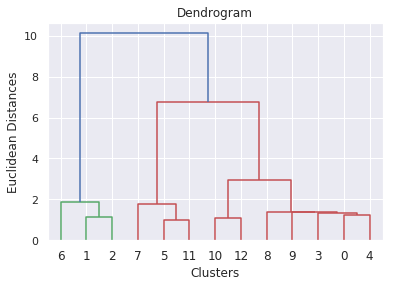

In [22]:
# Use a dendrogram to find optimal number of clusters
import scipy.cluster.hierarchy as sch
X = cities_grouped
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distances')
plt.show()



In [24]:
# 
cities_grouped.head()

,Cluster,Accessories Store,American Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Big Box Store,Bookstore,Border Crossing,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Café,Cemetery,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Department Store,Diner,Discount Store,Donut Shop,Fabric Shop,Farmers Market,Fast Food Restaurant,Flea Market,Food,French Restaurant,Furniture / Home Store,Garden Center,...,New American Restaurant,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Pub,Rental Car Location,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Southern / Soul Food Restaurant,Spa,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Weight Loss Center,Wine Shop,Wings Joint,Women's Store
0,4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,8,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.142857
3,4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [25]:
# Add lat, and lng back in the dataframe
cities_merged = cities_grouped
cities_merged = cities_merged.join(cities_venues_df.set_index(cities_venues_df.index))
cities_merged = cities_merged.drop(['name', 'categories', 'address', 'city'], axis=1)
# Clear all NaNs from lat, lng, and distance
cities_merged = cities_merged.dropna(subset=['lat', 'lng', 'distance'])
#cities_merged
X = cities_merged
# Fit transform data again to take care of ln and distances
cluster_dataset = StandardScaler().fit_transform(X)

num_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=num_clusters, max_iter=1200, algorithm='auto')
kmeans.fit(cluster_dataset)
prediction = kmeans.predict(cluster_dataset)
labels = kmeans.labels_
print("Prediction is {}".format(prediction))
print("Labels are    {}".format(labels))


Prediction is [0 4 6 0 9 8 7 2 0 5 3 1]
Labels are    [0 4 6 0 9 8 7 2 0 5 3 1]


In [26]:
cluster_dataset

array([[-0.27472113,  0.        , -0.62286726, ..., -0.35199567,
        -0.54912253,  0.87298433],
       [ 1.37360564,  0.        ,  2.22125218, ..., -0.44304175,
        -0.63828297,  0.45704071],
       [ 0.96152395,  0.        , -0.62286726, ..., -0.37423699,
        -0.60428096,  0.69397062],
       ...,
       [ 0.54944226,  0.        ,  1.20549523, ...,  1.33941722,
         1.29840416, -1.41909314],
       [-1.09888451,  0.        , -0.02758645, ...,  0.91614473,
         1.80000389, -0.46084329],
       [ 0.13736056,  0.        , -0.62286726, ...,  1.36460766,
         1.12535163, -0.74164911]])

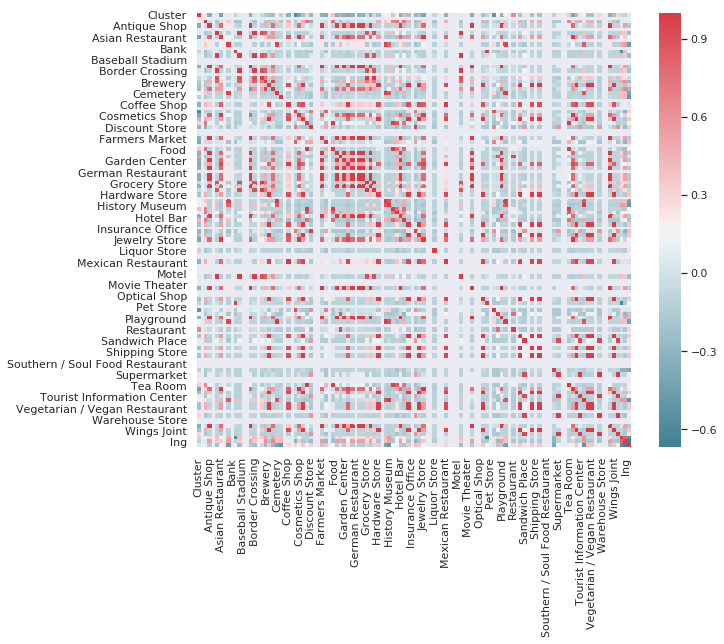

In [34]:
# A correlation heapmap of all the features in the dataset
import seaborn as sns; sns.set()
X = cities_merged
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
  

    
  

In [36]:
# Let's visualize the clusters generated by kmeans and compare to the original map visually
# Map all the business locations in the 10-miles radius centered around Falling Waters, WV.
# 
kmeans_cluster_map = folium.Map(location=falling_waters, zoom_start=13) # generate map centred around Falling Waters
  
# set color scheme for the clusters
kclusters = 11
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(cities_merged['lat'], cities_merged['lng'], cities_merged['Cluster']):
    label = folium.Popup('Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=25,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(kmeans_cluster_map)
    
# Let's also super impose the actual locations of the business and see how they align with the cluster centroids generated by the k-means algorighm 
 # add the proposed location as a blue circle
for lat, lng, label, distance in zip(cities_venues_df['lat'], 
                                     cities_venues_df['lng'], cities_venues_df['categories'], cities_venues_df['distance']):
    miles = round(distance/1610, 2)
    popup_label = str(label) + "  " + str(miles) + " miles."
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color='blue',
        popup=popup_label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6,
        parseHTML=False).add_to(kmeans_cluster_map)
     
  
kmeans_cluster_map

In [37]:
# Fitting hierarchical Clustering to the dataset using Agglomerative Clustering
X = cities_merged
from sklearn.cluster import AgglomerativeClustering
h_clusters = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
y_h_clusters = h_clusters.fit_predict(X)

y_h_clusters


array([9, 1, 7, 8, 1, 0, 0, 5, 4, 6, 2, 3])

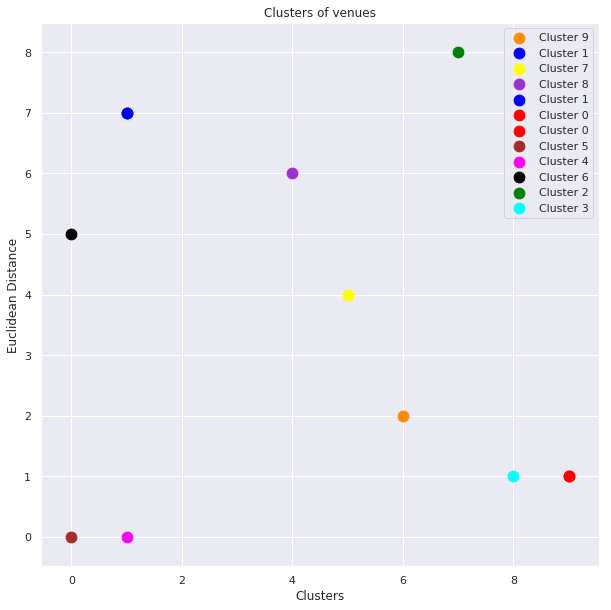

In [39]:
# Visualising the clusters
X = y_h_clusters
color_array = ['red', 'blue', 'green', 'cyan', 'magenta', 'brown', 'black', 'yellow', '#9932cc', '#ff8c00', 'purple']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']
for i in X:
    plt.scatter(X[i], X[i + 1], s = 116, c = color_array[i], label = labels[i])
  
plt.title('Clusters of venues')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.legend(loc='upper right')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.show()